In [3]:
%matplotlib inline
import pyart
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

In [4]:
radar = pyart.io.read('MDV-20150805-102446-PPIVol.nc')
radar.info('compact')

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: None
antenna_transition: None
azimuth: <ndarray of type: float32 and shape: (9270,)>
elevation: <ndarray of type: float32 and shape: (9270,)>
fields:
	DBZH: <ndarray of type: float32 and shape: (9270, 2500)>
	DBZV: <ndarray of type: float32 and shape: (9270, 2500)>
	VELH: <ndarray of type: float32 and shape: (9270, 2500)>
	VELV: <ndarray of type: float32 and shape: (9270, 2500)>
fixed_angle: <ndarray of type: float32 and shape: (18,)>
instrument_parameters:
	frequency: <ndarray of type: float32 and shape: (1,)>
	pulse_width: <ndarray of type: float32 and shape: (9270,)>
	prt_mode: <ndarray of type: |S1 and shape: (18, 10)>
	prt: <ndarray of type: float32 and shape: (9270,)>
	prt_ratio: <ndarray of type: float32 and shape: (9270,)>
	polarization_mode: <ndarray of type: |S1 and shape: (18, 10)>
	nyquist_velocity: <ndarray of type: float32 and shape: (9270,)>
	n_samples: <ndarray of type: int32 and shape: (9270,)>
	radar_a

In [5]:
radar.fields

{'DBZH': {'long_name': 'equivalent_reflectivity_factor_h',
  'units': 'dBZ',
  '_FillValue': -32768,
  'coordinates': 'elevation azimuth range',
  'data': masked_array(
    data=[[6.0, 10.0, -13.0, ..., 22.0, 23.5, 24.5],
          [7.5, 8.5, -12.5, ..., 25.0, 25.5, 25.5],
          [5.5, 7.5, -15.0, ..., 25.5, 24.5, 22.0],
          ...,
          [5.0, 6.5, -16.5, ..., --, --, --],
          [6.0, 7.0, -13.0, ..., --, --, --],
          [5.5, 7.0, -14.5, ..., --, --, --]],
    mask=[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ...,  True,  True,  True],
          [False, False, False, ...,  True,  True,  True],
          [False, False, False, ...,  True,  True,  True]],
    fill_value=-32768,
    dtype=float32)},
 'DBZV': {'long_name': 'equivalent_reflectivity_factor_v',
  'units': 'dBZ',
  '_FillValue': -32768,
  'co

In [6]:
radar.get_slice(0)

slice(0, 515, None)

In [7]:
def check_dimensions(radar, field='DBZH'):
    """
    Check if field dimensions are constants across elevations
    """
    dim0 = radar.fields[field]['data'][radar.get_slice(0)].shape
    for ns in range(0, radar.nsweeps):
        if dim0 != radar.fields[field]['data'][radar.get_slice(ns)].shape:
            raise ValueError("dimension mismatch.")
    return True

In [8]:
cappi_altitude = 2

In [9]:
# Reshape field into a 3D array (elevation, azimuth, range)
#if check_dimensions(radar):
refl = radar.fields['DBZH']['data'].copy()
dim0 = refl[radar.get_slice(0)].shape

ref3dorig = refl.reshape((radar.nsweeps, dim0[0], dim0[1]))
ref3d = np.zeros_like(ref3dorig)

# Sorting azimuth, put azimuth 0 at index 0, second azimuth at index 1, ...
for ns in range(radar.nsweeps):
    azi = radar.azimuth['data'][radar.get_slice(ns)]
    pos = np.argsort(azi)    
    for i, p in enumerate(pos):
        ref3d[ns, i, :] = ref3dorig[ns, p, :].copy()

In [10]:
elevation = np.unique(radar.elevation['data'])
r = radar.range['data']
azi = np.linspace(0, 359, dim0[0])

# Convert azimuth to polar
theta = (450 - azi)
theta[theta >= 360] -= 360

THETA, PHI, R = np.meshgrid(theta, elevation, r)

# Radar spherical to cartesian
X = R * np.cos(PHI * np.pi / 180) * np.cos(THETA * np.pi / 180)
Y = R * np.cos(PHI * np.pi / 180) * np.sin(THETA * np.pi / 180)
Z = R * np.sin(PHI * np.pi / 180)

In [11]:
posslice = np.argmin(np.abs(Z - cappi_altitude), axis=0)

CAPPI = np.zeros((dim0[0], dim0[1]))
XC = np.zeros((dim0[0], dim0[1]))
YC = np.zeros((dim0[0], dim0[1]))


In [12]:
posslice.shape,ref3d.shape

((515, 2500), (18, 515, 2500))

In [13]:
for i in range(dim0[1]):
    for j in range(dim0[0]):
        CAPPI[j, i] = ref3d[posslice[j, i], j, i]
        XC[j, i] = X[posslice[j, i], j, i]
        YC[j, i] = Y[posslice[j, i], j, i]

In [14]:
radar.fields['DBZH']['data'].shape,CAPPI.shape

((9270, 2500), (515, 2500))

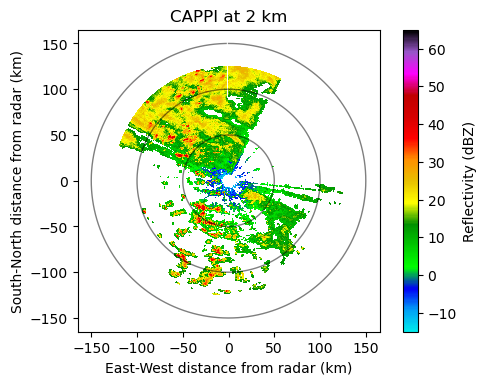

In [15]:
fig, ax = plt.subplots(1, 1,dpi=100)
im = ax.pcolormesh(XC / 1e3, YC / 1e3, CAPPI, cmap='pyart_NWSRef', vmin=-15, vmax=65)
fig.colorbar(im, ax=ax, label='Reflectivity (dBZ)')
[ax.plot(r * np.cos(theta * np.pi / 180), r * np.sin(theta * np.pi / 180), 'k', linewidth=1, alpha=0.5) 
for r in [50, 100, 150]]
ax.set_aspect(1)
ax.set_xlabel('East-West distance from radar (km)')
ax.set_ylabel('South-North distance from radar (km)')
ax.set_title(f'CAPPI at {cappi_altitude} km')
plt.show()

In [16]:
pd.DataFrame(posslice).describe()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
count,515.0,515.0,515.0,515.0,515.0,515.0,515.0,515.0,515.0,515.0,...,515.0,515.0,515.0,515.0,515.0,515.0,515.0,515.0,515.0,515.0
mean,15.0,5.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,15.0,5.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,15.0,5.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,15.0,5.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,15.0,5.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,15.0,5.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
